In [61]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

### 손글씨 데이터 불러오기

In [62]:
(x_train , y_train) , (x_test , y_test) = keras.datasets.mnist.load_data()

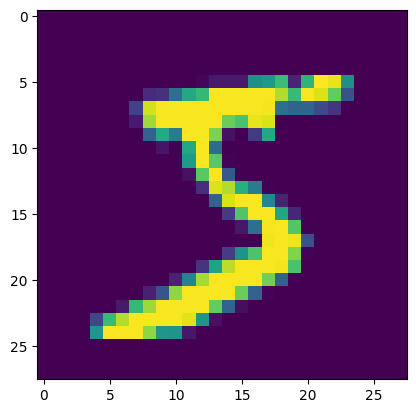

In [63]:
plt.imshow(x_train[0])

### 3D vector 변환

In [64]:
width , height , channel = 28, 28, 1
x_train = x_train.reshape(x_train.shape[0],width, height, channel)
print(x_train.shape)

(60000, 28, 28, 1)


In [65]:
# image pixel normalization [ 0 , 255 ] -> [-1 , 1]
# 왜냐 강화학습에서는 adam 보다는 tanh 를 더 많이 사용한다.
X = (x_train - 127.5) / 127.5


### 이미지 시각화

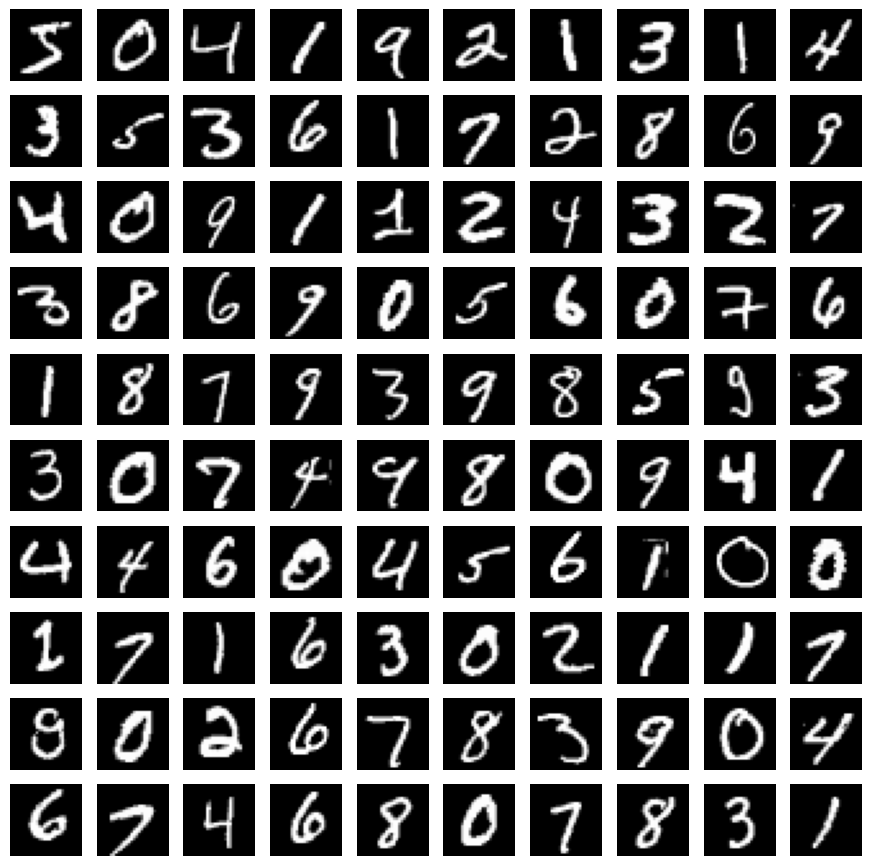

In [66]:
plt.figure(figsize=(11,11))

i = 1
for image in X:
    plt.subplot(10, 10, i)
    image = image.reshape(width , height )
    plt.imshow(image,cmap='gray')
    plt.axis('off')
    i += 1
    if i > 100 : break

plt.show()

### 강화학습으로 새로운 이미지 만들기

In [67]:
import tensorflow as tf

In [68]:
# 학습 데이터 batch 준비
BATCH_SIZE = 64

# BATCH size 나누기
train_dataset = tf.data.Dataset.from_tensor_slices(X).batch(BATCH_SIZE) # 데이터를 batch size 만큼 나눠서 쓴다.
train_dataset

<BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float64, name=None)>

#### 생성자 모델 (Generator Model)

In [69]:
# Generator 모델 네트워크 구성

def build_generator_model():
    model = keras.Sequential() # Keras 모델 생성

    model.add(keras.layers.Dense(1024, input_dim=100, use_bias=False)) # 100 = 10*10
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())
    
    model.add(keras.layers.Dense(7*7*128, use_bias=False)) # 28 / 4 = 7
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())
    
    # Resahpe (7*7)
    model.add(keras.layers.Reshape((7, 7, 128)))  # 28 / 4 = 7
    
    model.add(keras.layers.Conv2DTranspose(112, (5, 5), # 28 * 2 * 2
                                    strides=(1, 1), padding='same', use_bias=False))
    model.add(keras.layers.BatchNormalization()) 
    model.add(keras.layers.LeakyReLU())
    
    # (7*7) -> (14*14)
    model.add(keras.layers.Conv2DTranspose(56, (5, 5), # 28 * 2
                                    strides=(2, 2), padding='same', use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())
    
    # (14*14) -> (28*28)
    model.add(keras.layers.Conv2DTranspose(1, (5, 5), 
                                    strides=(2, 2), padding='same', activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [70]:
# 생성자 모델 생성
generator = build_generator_model()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1024)              102400    
                                                                 
 batch_normalization_4 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 6272)              6422528   
                                                                 
 batch_normalization_5 (Batc  (None, 6272)             25088     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 6272)             

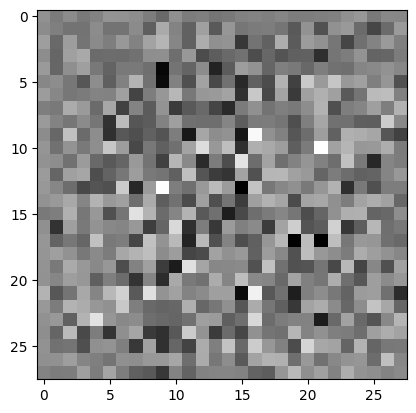

In [71]:
# 학습되지 않은 생성자 모델이 만든 이미지
noise = tf.random.normal([1,100]) # 100 : 출력 이미지 갯수
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0,:,:,0],cmap='gray')

--- 
### 판별자 모델 만들기

In [72]:
# Discriminator 모델 네트워크 구성

def build_discriminator_model():

    model = keras.Sequential()
    
    model.add(keras.layers.Conv2D(56, (5, 5), strides=2, padding='same',  # 56 = 28 * 2
                       input_shape=[28, 28, 1])) # input image size
    model.add(keras.layers.LeakyReLU(0.2))
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Conv2D(112, (5, 5), strides=2, padding='same')) # 112 = 56 * 2
    model.add(keras.layers.LeakyReLU(0.2))
    
    model.add(keras.layers.Flatten())
    
    model.add(keras.layers.Dense(224)) # 224 = 112 * 2
    model.add(keras.layers.LeakyReLU(0.2))
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Dense(1))
    
    return model

In [73]:
# 판별자 모델 만들기
discriminator = build_discriminator_model()
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 56)        1456      
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 14, 14, 56)        0         
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 56)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 112)         156912    
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 7, 7, 112)         0         
                                                                 
 flatten_1 (Flatten)         (None, 5488)              0         
                                                                 
 dense_6 (Dense)             (None, 224)              

### 학습되지 않은 판별자의 결과 보기

In [74]:
predicted = discriminator(generated_image)
print(predicted)

tf.Tensor([[0.00130162]], shape=(1, 1), dtype=float32)


---
### Optimizer + Loss Function

In [75]:
# Optimizer 생성
# 생성자용
generator_optimizer = keras.optimizers.Adam(learning_rate=1e-4)

# 판별자용
discriminator_optimizer = keras.optimizers.Adam(learning_rate=1e-4)

In [76]:
# Binary Crossentropy for MinMax
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)

In [77]:
# Generator Loss 함수
# 생성자 모델의 목표는 : 
# 판별자 모델의 가짜 이미지를 판별했을 때 판별 값이 1에 가까워 지도록 만드는 것이다.
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output) # 1이라고 리턴 하지 않는게 ones_like 함수 이다.

In [78]:
# Discriminator Loss 함수
# 판별자 모델의 목표는 : 
# 1. 진짜 이미지를 판별했을 때 판별값이 1에 가까워 지도록
# 2. 가짜 이미지를 판별했을 때 판별값이 0에 가까워 지도록 만든다.
def discriminator_loss(real_output,fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output) # 1과 진짜 이미지 판별 값 비교
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) # 0과 가짜 이미지 판별 값 비교
    total_loss = real_loss + fake_loss
    return total_loss


---
### 강화 학습

In [79]:
# 학습값 설정
EPOCHS = 100
noise_dim = 100 # epochs , noise_dim 은 같게 한다. epochs를 통해 noise data를 점점점점 지우는 것이다.

In [80]:
# tf.function 에서는 파이썬 코드의 문장 실행 순서를 참조하여 실행 순서의 모호성을 해결합니다. tensorflow에서는 사용하는 것이 좋다.
@tf.function
def train_step(images):
    # 생성자 input noise
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    # Gradient descent 계산 및 파라미터 업데이트
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True) # 진짜 이미지를 봤을 때의 판별 값
      fake_output = discriminator(generated_images, training=True) # 가짜 이미지를 봤을 때의 판별 값

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [81]:
# 테스트 노이즈 시각화 함수

test_noise = tf.random.normal([100, noise_dim]) # 학습 시각화를 위한 테스트 노이즈 100개

def show_generated_images(epoch):
    images = generator.predict(test_noise)
    images = 0.5 * images + 0.5 # tanh는 sigmoid보다 데이터 범위가 2배가 더 크므로 이를 조정 
    
    plt.figure(figsize=(11,11))
    
    i = 1
    for image in images:
        image = image.reshape(width, height)
        plt.subplot(10, 10, i)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        i+=1

    plt.suptitle("Generated Images on EPOCH: %s" % epoch, fontsize = 25)
    plt.show()

In [82]:
# 학습코드
def train(dataset,epochs):
    for epoch in range(epochs):
        for image_batch in dataset: # batch학습 : 64
            train_step(image_batch)
        print('%s epochs trained'%epoch)
        if epoch % 5 == 0:
            show_generated_images(epoch)

0 epochs trained
4/4 [==============================] - 0s 10ms/step


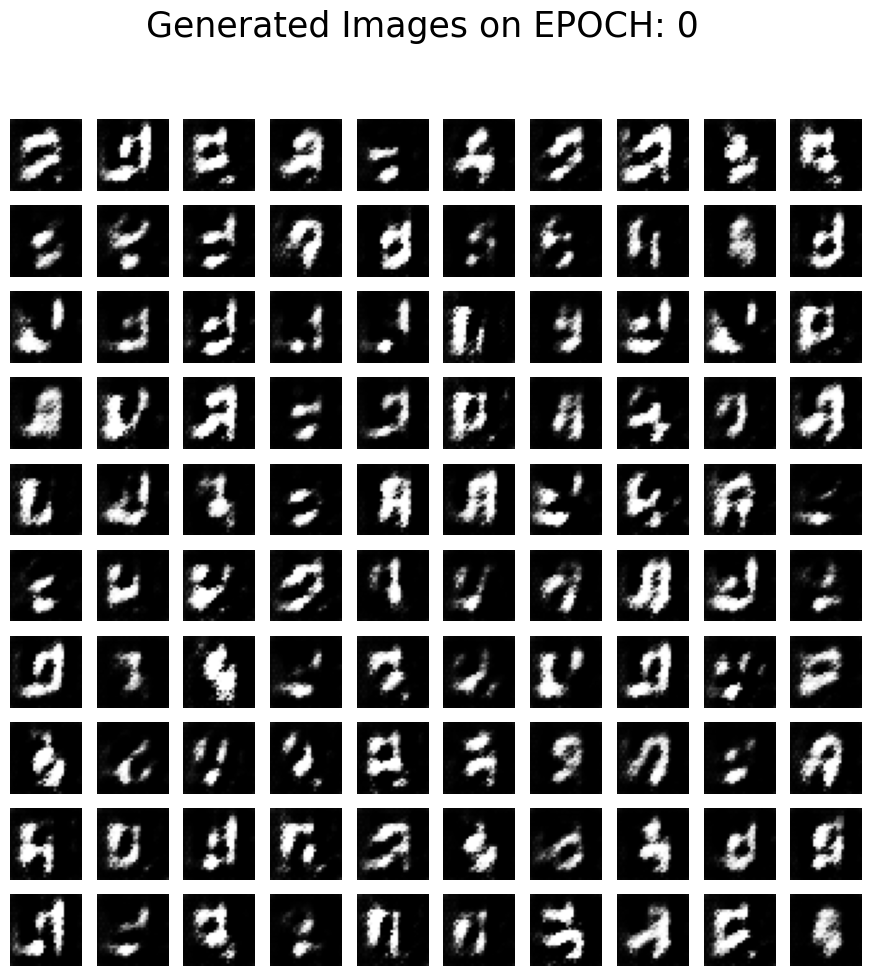

1 epochs trained
2 epochs trained
3 epochs trained
4 epochs trained
5 epochs trained
4/4 [==============================] - 0s 12ms/step


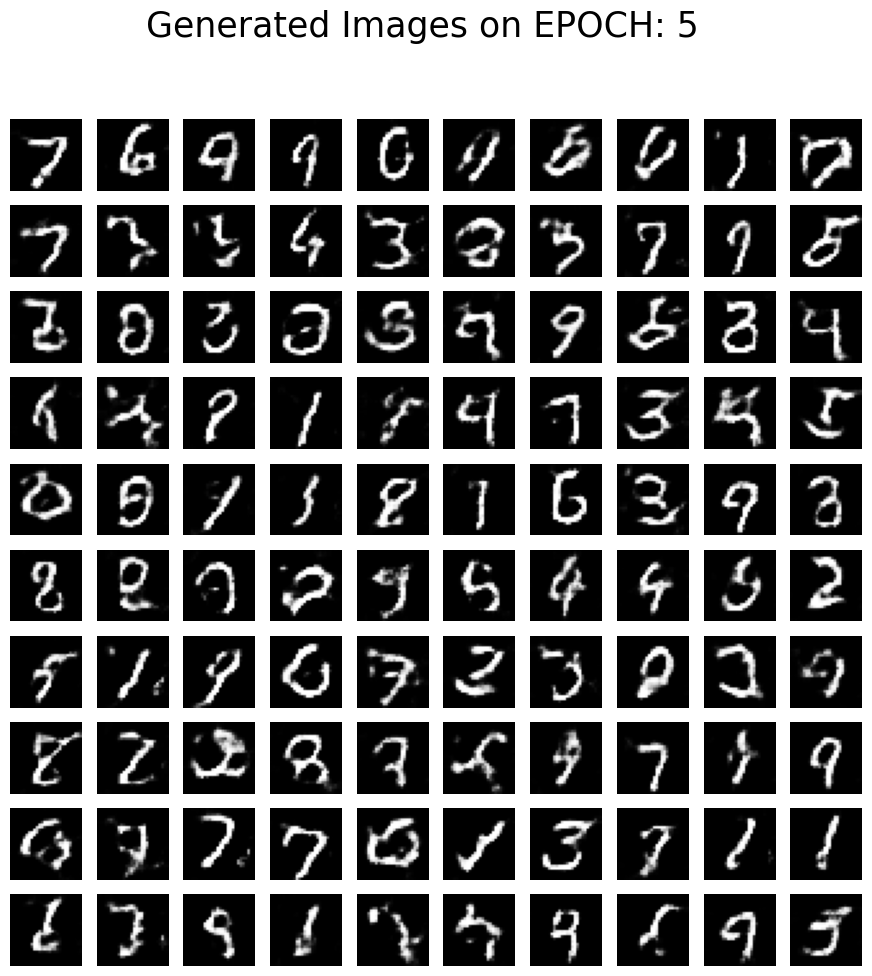

6 epochs trained
7 epochs trained
8 epochs trained
9 epochs trained
10 epochs trained
4/4 [==============================] - 0s 11ms/step


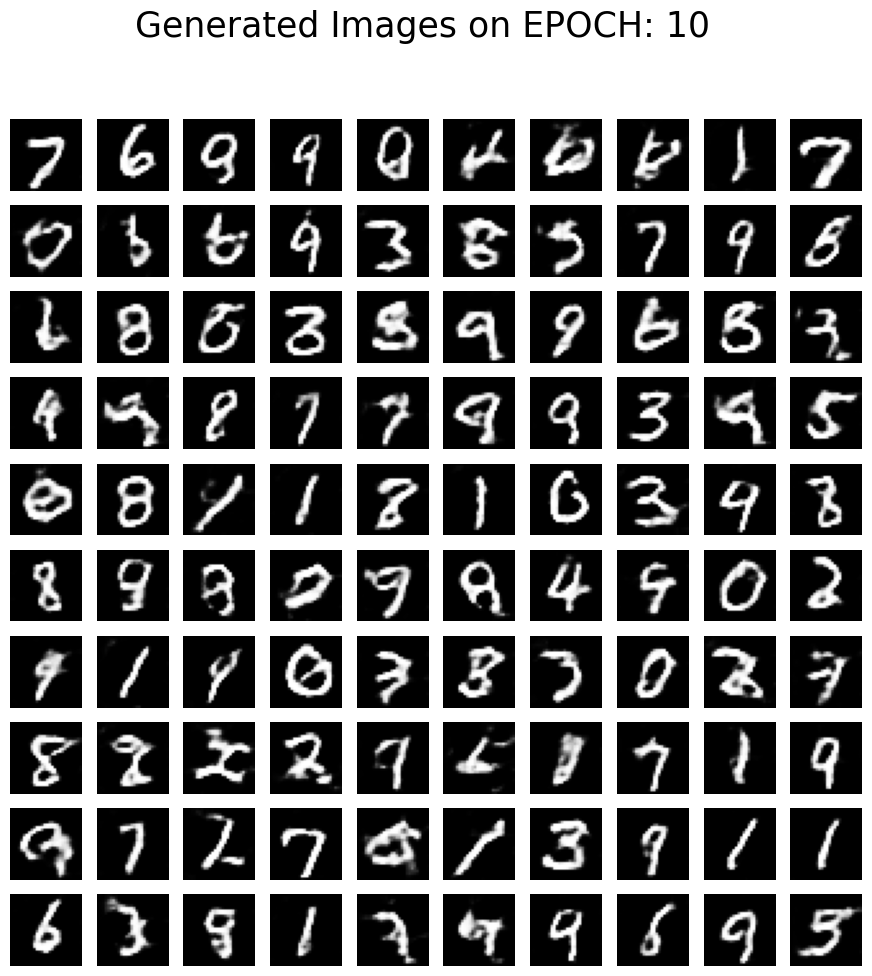

11 epochs trained
12 epochs trained
13 epochs trained


KeyboardInterrupt: 

In [83]:
# 학습 시작
train(train_dataset,EPOCHS + 1)